### Import all packages

In [14]:
import sys
sys.path.append("..") 

In [15]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import os
import torch.cuda
import albumentations as albu
import segmentation_models_pytorch as smp
from  segmentation_models_pytorch.utils.base import Metric
from segmentation_models_pytorch.base.modules import Activation
from collections import defaultdict
import nibabel as nib
from tqdm import tqdm
from Utils.dataset_utils import *

In [16]:
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [17]:
VOLUMES_BASE_PATH=Path(r'G:\Projects and Work\Mouse Heart Segmentation\Mice_CT_Dataset')
LABELS_TO_KEEP=[1,600,420,550,205]
SUBJECTS=os.listdir(VOLUMES_BASE_PATH/'volumes')
# SUBJECTS = [ 'C57-#10-MicroCT-020421 - Cardiac CT_110016-systole',
#             'C57-#9-MicroCT-020421 - Cardiac CT_105254-systole',
#             'C57-UmaControl#2-MicroCT-070120 - Cardiac CT_115916-diastole',
#             'C57-UmaControl#3-MicroCT-070120 - Cardiac CT_121937-systole',
#             'C57-#6-MicroCT-020421 - Cardiac CT_110734-systole',
#             'C57-#8-MicroCT-020421 - Cardiac CT_104450-systole',
#             'C57-UmaControl#1-MicroCT-070120 - Cardiac CT_115114-systole',
#             'C57-UmaControl#2-MicroCT-070120 - Cardiac CT_115916-systole',
#           ]

In [18]:
os.listdir(VOLUMES_BASE_PATH)

['Axials', 'labels', 'volumes']

In [19]:
WIDTH=512
HEIGHT=512

In [20]:
# def normalize(data):
#     data=(data-np.min(data))/(np.max(data)-np.min(data))
#     return data
# def load_volume(image_nifty_file, label_nifty_file):
#     # load the image and label file, get the image content and return a numpy array for each
#     label = None
#     vol = (nib.load(image_nifty_file))
#     image=np.array(vol.get_fdata())
#     affine=vol.affine
#     if os.path.exists(label_nifty_file):
#         label = np.array(nib.load(label_nifty_file).get_fdata())
#     return image, label,affine
def convert_labels(label_volume):
    new_labels=np.zeros(label_volume.shape)
    for lbl in np.unique(label_volume):
        if lbl in LABELS_TO_KEEP:
            new_labels[np.where(label_volume==lbl)]=1
    return new_labels

def to_tensor(x, **kwargs): 
    x= torch.from_numpy(x.transpose(2, 0, 1).astype('float32'))
    return x

def create_folder(path):
    if os.path.exists(path)==False:
        os.mkdir(path)
    

In [21]:
def predict_img(model,img):
    img=preprocessing_fn(img)
    img=to_tensor(img)
    img = img.to(device=DEVICE)
    img=torch.unsqueeze(img,dim=0)
    pred_mask=torch.squeeze(model(img))
    pred_mask=pred_mask.detach().cpu().numpy()
    return pred_mask
def prepare_slice(img):
    img=normalize(img)
    img = img*255
    img =img.astype('uint8')
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    return img
def predict_volume(model,volume,all_axials=False):
    pred_vol=np.zeros(volume.shape)
    out_Z=np.zeros(volume.shape)
    if all_axials:
        out_X=np.zeros(volume.shape)
        out_Y=np.zeros(volume.shape)
    X,Y,Z=volume.shape
    for i in tqdm(range(Z)):
        img = prepare_slice(volume[:,:,i])
        pred_mask=predict_img(model,img)
        out_Z[:,:,i]=pred_mask
        
    if all_axials:
        for i in tqdm(range(Y)):
            img = prepare_slice(volume[:,i,:])
            pred_mask=predict_img(model,img)
            out_Y[:,i,:]=pred_mask
        for i in tqdm(range(X)):
            img = prepare_slice(volume[i,:,:])
            pred_mask=predict_img(model,img)
            out_X[i,:,:]=pred_mask
        pred_vol=(out_X+out_Y+out_Z)/3.0
        pred_vol[pred_vol>0.5]=1
        pred_vol[pred_vol<0.5]=0
        return pred_vol
    else:
        return out_Z

In [22]:
# Model to choose
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'
MODEL_NAME='Unet'
BEST_WEIGHTS=r'G:\Projects and Work\Mouse Heart Segmentation\Trained Weights - Mice\imagenet\Unet_se_resnext50_32x4d\best.pt'
OUTPUT_PATH=Path(r'G:\Projects and Work\Mouse Heart Segmentation\Trained Weights - Mice\imagenet\Unet_se_resnext50_32x4d\Outputs')
create_folder(OUTPUT_PATH)

In [23]:
# Load model
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
best_model = torch.load(BEST_WEIGHTS)

In [24]:
# function to save numpy volume array to .nii
def save_mask_nii(volume_arr,affine,path):
    ni_img = nib.Nifti1Image(volume_arr,affine)
    nib.save(ni_img, path)

In [27]:
# Run a model on all volumes

for i in range(len(SUBJECTS)):
    print(SUBJECTS[i])
    subject_path = os.path.join(VOLUMES_BASE_PATH,'volumes',SUBJECTS[i],f'{SUBJECTS[i]}_volume.nii') # volume path
    if os.path.exists(subject_path) is False:
        continue
    subject_label_path = os.path.join(VOLUMES_BASE_PATH,'labels',SUBJECTS[i],f'{SUBJECTS[i]}_label.nii') #volume label
    if os.path.exists(subject_label_path)==False: # checking if extension is .nii or .nii.gz 
        subject_label_path = os.path.join(VOLUMES_BASE_PATH,'labels',SUBJECTS[i],f'{SUBJECTS[i]}_label.nii.gz')   
    subject_name = SUBJECTS[i]
    if os.path.exists(os.path.join(OUTPUT_PATH,subject_name)):
        continue
    create_folder(os.path.join(OUTPUT_PATH,subject_name)) # create output folder
    volume, volume_gt_mask,affine = load_case(subject_path,subject_label_path) # Load volume with its affine and mask
#     volume_gt_mask=convert_labels(volume_gt_mask)
    volume_pred_mask=predict_volume(best_model,volume,False)   # Predict volume
    volume_pred_mask=np.round(volume_pred_mask)
    save_mask_nii(volume_pred_mask,affine,os.path.join(OUTPUT_PATH,subject_name,'prediction_mask.nii.gz'))    #save predicted volume
    if volume_gt_mask is not None:     # save grouth truth .nii file also for convinience
        save_mask_nii(volume_gt_mask,affine,os.path.join(OUTPUT_PATH,subject_name,'ground_truth_mask.nii.gz'))

C57-#1-MicroCT-011421 - Cardiac CT_144223-diastole
C57-#1-MicroCT-011421- Cardiac CT_144223-systole
C57-#10-MicroCT-020421 - Cardiac CT_110016-diastole
C57-#10-MicroCT-020421 - Cardiac CT_110016-systole
C57-#2-MicroCT-011421 - Cardiac CT_141319-systole
C57-#2-MicroCT-011421 Cardiac CT_141319-diastole
C57-#3-MicroCT-011421 - Cardiac CT_150456-diastole
C57-#3-MicroCT-011421 - Cardiac CT_150456-systole
C57-#4-MicroCT-011421 - Cardiac CT_152627-systole
C57-#4-MicroCT-011421- Cardiac CT_152627-diastole
C57-#5-MicroCT-011421 - Cardiac CT_153927-diastole
C57-#5-MicroCT-011421 - Cardiac CT_153927-systole
C57-#6-MicroCT-020421 - Cardiac CT_110734-diastole
C57-#6-MicroCT-020421 - Cardiac CT_110734-systole
C57-#7-MicroCT-020421 - Cardiac CT_111521-diastole
C57-#7-MicroCT-020421 - Cardiac CT_111521-systole
C57-#8-MicroCT-020421 - Cardiac CT_104450-diastole
C57-#8-MicroCT-020421 - Cardiac CT_104450-systole
C57-#9-MicroCT-020421 - Cardiac CT_105254-diastole
C57-#9-MicroCT-020421 - Cardiac CT_105254-

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [00:36<00:00, 13.93it/s]


LAD-#6-MicroCT-050321 - Cardiac CT_125739-systole


100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [00:34<00:00, 14.82it/s]


LAD-#7-MicroCT-050321 - Cardiac CT_130531-diastole
LAD-#7-MicroCT-050321 - Cardiac CT_130531-systole
LAD-#8-MicroCT-050321 - Cardiac CT_131303-diastole
LAD-#8-MicroCT-050321 - Cardiac CT_131303-systole
LAD-Uma#1-MicroCT-030519 - Cardiac CT_133621-diastole
LAD-Uma#1-MicroCT-030519 - Cardiac CT_133621-systole
LAD-Uma#5-MicroCT-030519 - Cardiac CT_134513-diastole
LAD-Uma#5-MicroCT-030519 - Cardiac CT_134513-systole
LADmice.zip
TAC-#3-MicroCT-050321 - Cardiac CT_115640-diastole
TAC-#3-MicroCT-050321 - Cardiac CT_115640-systole
TAC-#5-MicroCT-050321 - Cardiac CT_120528-diastole
TAC-#5-MicroCT-050321 - Cardiac CT_120528-systole
TAC-#8-MicroCT-050321 - Cardiac CT_124052-diastole
TAC-#8-MicroCT-050321 - Cardiac CT_124052-systole
TAC-U2-1-MicroCT100620 - Cardiac CT_100920-diastole
TAC-U2-1-MicroCT100620 - Cardiac CT_100920-systole
TAC-U2-2-MicroCT100620 - Cardiac CT_101711-diastole
TAC-U2-2-MicroCT100620 - Cardiac CT_101711-systole
TAC-U2-3-MicroCT100620 - Cardiac CT_102620-diastole
TAC-U2-3-Mi

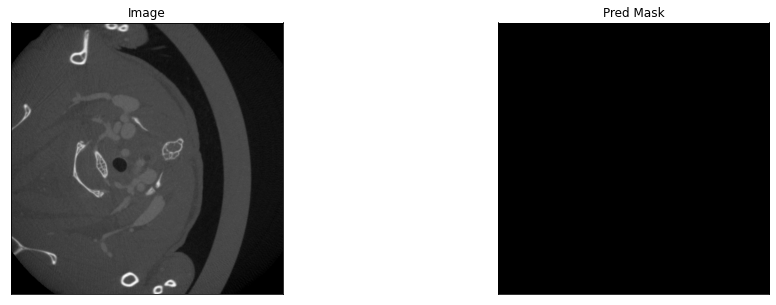

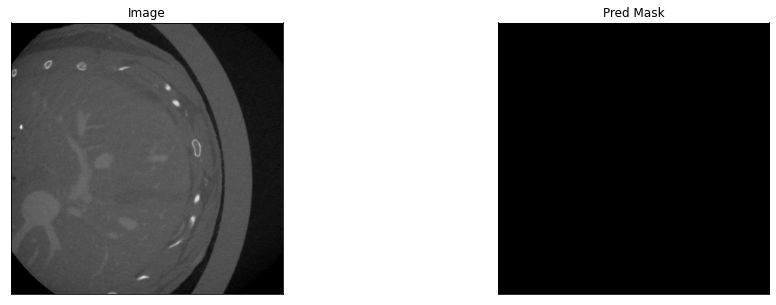

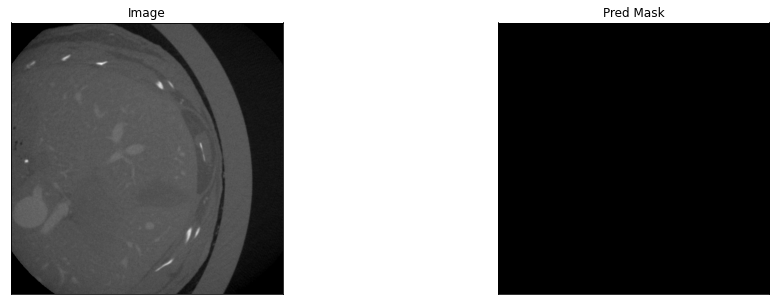

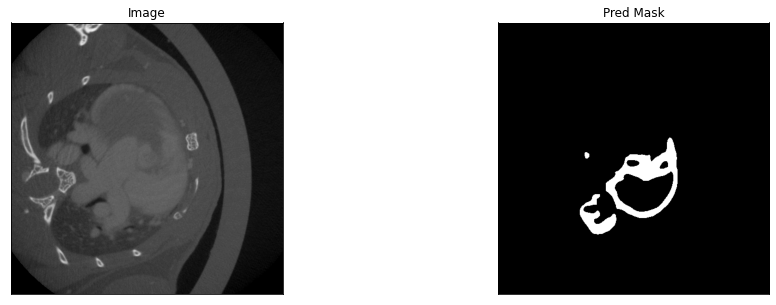

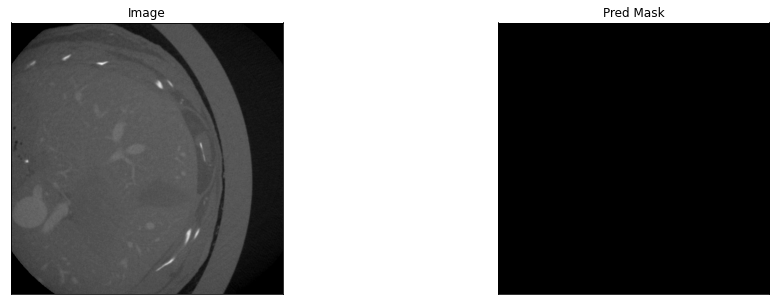

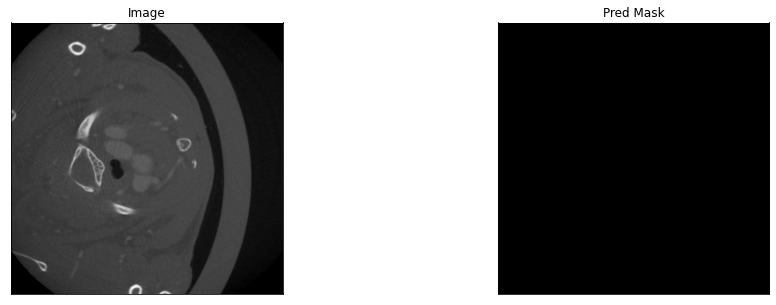

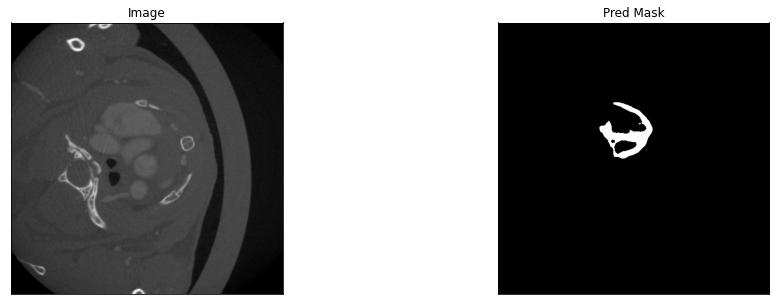

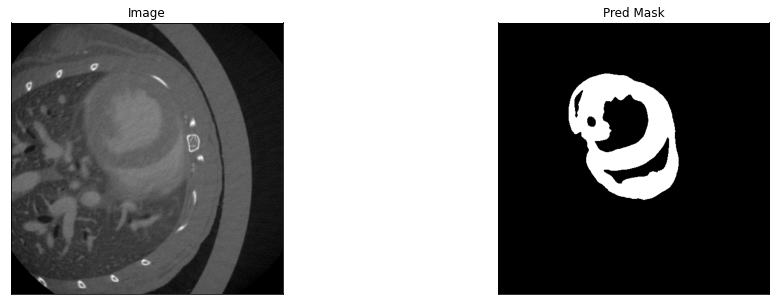

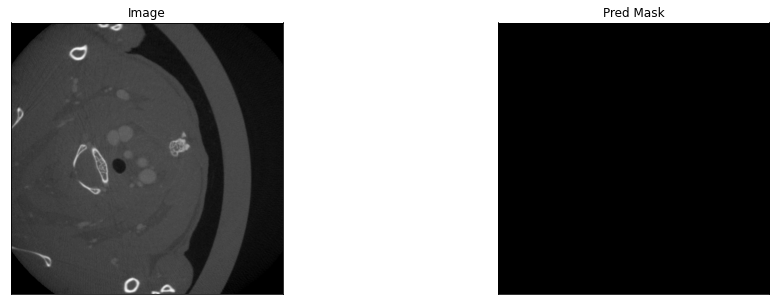

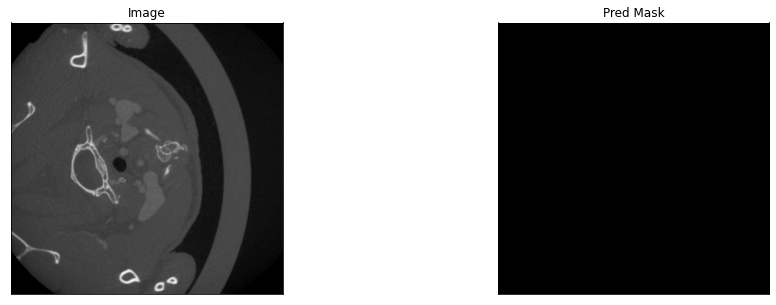

In [17]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap="gray")
    plt.show()

for i in range(10):
    n = np.random.choice(volume_pred_mask.shape[2])
    visualize(image=volume[:,:,n],gt_mask= volume_gt_mask[:,:,n],pred_mask=volume_pred_mask[:,:,n])
